<a href="https://colab.research.google.com/github/Lulu-1121/AIPI-590-XAI-Interpretable-ML/blob/main/Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Interpretable ML — Telco Customer Churn
## Hongyi Duan (hd162)

This notebook follows the assignment in “Interpretable ML”:

**Tasks**
1) Exploratory Data Analysis to check assumptions (linear, logistic, GAM)  
2) Linear Regression (treat `Churn` as continuous 0/1) with interpretation  
3) Logistic Regression with interpretation (odds ratios)  
4) Generalized Additive Model (GAM) to capture non‑linearities and interpret partial effects  
5) Model comparison + recommendations


## Setup

In [ ]:
# If running in Colab, this installs everything you need.
# Safe to run multiple times.
!pip -q install pandas numpy matplotlib seaborn scikit-learn statsmodels pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.2 MB/s eta 0:00:00


## Imports & Global Config

In [ ]:
import os, sys, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, average_precision_score,
                             confusion_matrix, classification_report, mean_squared_error,
                             r2_score, mean_absolute_error)
from sklearn.linear_model import LinearRegression, LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pygam import LogisticGAM, LinearGAM, s, f

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", 200)
sns.set_context("notebook")

## (Optional) Connect to GitHub Repo (as provided)

In [ ]:
# This cell mirrors the exact snippet you shared.
# It is optional for this notebook to run, but you can execute it if your workflow expects the repo.
import os

repo_name = "AIPI-590-XAI-Interpretable-ML"
git_path = 'https://github.com/Lulu-1121/AIPI-590-XAI-Interpretable-ML.git'
!git clone "{git_path}"

notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name, notebook_dir)

# Keep original working directory, cd into templates to list its contents, then cd back.
orig_dir = os.getcwd()
%cd "{path_to_notebook}"
%ls
%cd "{orig_dir}"

Cloning into 'AIPI-590-XAI-Interpretable-ML'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 164.20 KiB | 3.04 MiB/s, done.
[Errno 2] No such file or directory: 'AIPI-590-XAI-Interpretable-ML/templates'
/content
AIPI-590-XAI-Interpretable-ML/  sample_data/
/content



## Load Data

You have two simple options:

- **Upload** `data.csv` when prompted; or  
- Put `data.csv` in the working directory (e.g., `/content/data.csv` in Colab).

The loader below tries common locations and, if needed, opens a file‑upload dialog in Colab.


In [ ]:
DATA_FILE = "data.csv"  # change if your file has a different name

def load_telco_csv():
    # Try a few common paths first
    candidates = [DATA_FILE, "/content/data.csv", "telco.csv", "/content/telco.csv"]
    for p in candidates:
        if os.path.exists(p):
            print(f"Loading: {p}")
            return pd.read_csv(p)

    # If in Colab, prompt for upload
    try:
        from google.colab import files
        print("Couldn't find data file. Please upload your CSV (e.g., data.csv).")
        uploaded = files.upload()
        # Grab first uploaded file
        name = list(uploaded.keys())[0]
        print(f"Loading uploaded file: {name}")
        return pd.read_csv(name)
    except Exception as e:
        raise FileNotFoundError(
            "data.csv not found. Place it in the working directory or upload it when prompted."
        )

df_raw = load_telco_csv()
df_raw.head()

Couldn't find data file. Please upload your CSV (e.g., data.csv).


Saving data.csv to data.csv
Loading uploaded file: data.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## Basic Cleaning

We standardize common Telco‑Churn style columns if present:

- Ensure `Churn` is 0/1 (Yes→1, No→0).
- Convert `TotalCharges` to numeric (sometimes it's a string with blanks).
- Treat `SeniorCitizen` as 0/1 integer if present.
- Drop rows with missing target.


In [ ]:
df = df_raw.copy()

# Standardize likely column names (tolerant to variations)
colmap = {c.lower(): c for c in df.columns}
def get_col(name_opts):
    for n in name_opts:
        key = n.lower()
        if key in colmap:
            return colmap[key]
    return None

churn_col = get_col(["Churn","churn"])
if churn_col is None:
    raise ValueError("Target column 'Churn' not found. Please ensure your CSV has a 'Churn' column (0/1 or Yes/No).")

# Normalize churn to 0/1
if df[churn_col].dtype == object:
    df[churn_col] = df[churn_col].str.strip().str.lower().map({"yes":1, "no":0, "1":1, "0":0})
df[churn_col] = df[churn_col].astype("Int64")

# Common numeric columns that may arrive as strings
for maybe_num in ["TotalCharges","totalcharges"]:
    c = get_col([maybe_num])
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors="coerce")

senior_col = get_col(["SeniorCitizen","seniorcitizen"])
if senior_col is not None:
    df[senior_col] = pd.to_numeric(df[senior_col], errors="coerce").fillna(0).astype(int)

# Drop rows with missing target
before = len(df)
df = df.dropna(subset=[churn_col]).copy()
after = len(df)
print(f"Dropped {before - after} rows with missing target. Final shape: {df.shape}")

df.head()

Dropped 0 rows with missing target. Final shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1



## EDA & Assumption Checks

We’ll quickly explore distributions and relationships needed for model assumptions:

- **Target balance** (class imbalance for logistic).  
- **Categorical vs churn**: churn rates by category.  
- **Numeric vs churn**: quick correlations & trends.  
- **Missingness** overview.


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


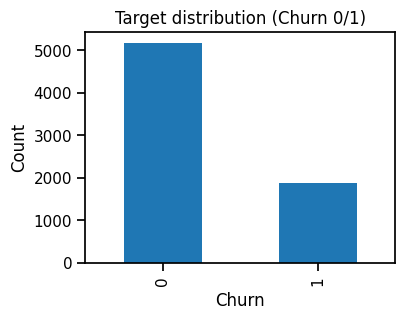

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'] 
Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV'] ...


,corr_with_churn
Churn,1.000000
MonthlyCharges,0.193356
SeniorCitizen,0.150889
TotalCharges,-0.199484
tenure,-0.352229


In [ ]:
# Basic info
display(df.describe(include="all").T)

# Target distribution
y = df[churn_col].astype(int)
fig, ax = plt.subplots(figsize=(4,3))
y.value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Target distribution (Churn 0/1)")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
plt.show()

# Split columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if churn_col in numeric_cols:
    numeric_cols.remove(churn_col)
categorical_cols = [c for c in df.columns if c not in numeric_cols + [churn_col]]

print("Numeric columns:", numeric_cols[:12], "..." if len(numeric_cols)>12 else "")
print("Categorical columns:", categorical_cols[:12], "..." if len(categorical_cols)>12 else "")

# Correlation with churn for numeric features
if numeric_cols:
    corr = df[numeric_cols + [churn_col]].corr(numeric_only=True)[churn_col].sort_values(ascending=False)
    display(corr.to_frame("corr_with_churn").style.background_gradient(cmap="coolwarm"))


## Modeling Setup

We’ll build a consistent preprocessing pipeline:

- One‑hot encode categoricals  
- Standardize numeric features  
- Train/test split (stratified by churn)


In [ ]:
# One-hot encode categoricals
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True, dtype=float)

X = df_model.drop(columns=[churn_col])
y = df_model[churn_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize numeric features only
num_ix = [i for i,c in enumerate(X.columns) if c in numeric_cols]
ct = ColumnTransformer([("scaler", StandardScaler(), num_ix)], remainder="passthrough")

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, #features: {X.shape[1]}")

Train shape: (4930, 7072), Test shape: (2113, 7072), #features: 7072



## 1) Linear Regression (Churn as 0/1 continuous)

- Fit linear regression and evaluate RMSE/MAE/R².  
- Treat outputs as pseudo‑probabilities to compute ROC‑AUC.  
- Inspect top coefficients by magnitude and check residuals (linearity & normality hints).


Linear Regression — RMSE: 0.1428  MAE: 0.2979  R²: 0.2675  ROC-AUC: 0.8311


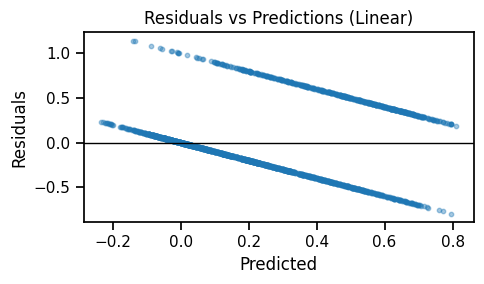

,feature,coef,abs_coef
6097,customerID_8631-NBHFZ,1.129727,1.129727
1596,customerID_2321-OMBXY,1.109691,1.109691
4180,customerID_5906-CVLHP,1.107239,1.107239
256,customerID_0378-XSZPU,1.105921,1.105921
5232,customerID_7359-SSBJK,1.092695,1.092695
3023,customerID_4322-RCYMT,1.091483,1.091483
4634,customerID_6532-YLWSI,1.073862,1.073862
3081,customerID_4404-HIBDJ,1.063082,1.063082
1517,customerID_2225-ZRGSG,1.062571,1.062571
384,customerID_0565-IYCGT,1.058598,1.058598


In [ ]:
# Use pipeline with imputer + scaler + linear regression
from sklearn.impute import SimpleImputer

# numeric columns indexes for ColumnTransformer
num_ix = [i for i, c in enumerate(X.columns) if c in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # fill missing values with median
    ("scaler", StandardScaler())
])

ct = ColumnTransformer(
    transformers=[("num", numeric_transformer, num_ix)],
    remainder="passthrough"
)

linr = Pipeline([("prep", ct), ("model", LinearRegression())])
linr.fit(X_train, y_train)
linr_pred = linr.predict(X_test)

rmse = mean_squared_error(y_test, linr_pred)
mae = mean_absolute_error(y_test, linr_pred)
r2 = r2_score(y_test, linr_pred)
linr_auc = roc_auc_score(y_test, np.clip(linr_pred, 0, 1))

print(f"Linear Regression — RMSE: {rmse:.4f}  MAE: {mae:.4f}  R²: {r2:.4f}  ROC-AUC: {linr_auc:.4f}")

# Residual diagnostics
resid = y_test.to_numpy() - linr_pred
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(linr_pred, resid, alpha=0.4, s=10)
ax.axhline(0, color="k", linewidth=1)
ax.set_title("Residuals vs Predictions (Linear)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Residuals")
plt.tight_layout(); plt.show()

# Coefficients
scaled_num_names = [X.columns[i] for i in num_ix]
other_names = [c for i, c in enumerate(X.columns) if i not in num_ix]
feature_names = scaled_num_names + other_names

coefs = linr.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(20)


## 2) Logistic Regression

- Fit logistic regression with L2 regularization and `class_weight='balanced'` if the classes are imbalanced.  
- Evaluate: Accuracy, Precision, Recall, F1, ROC‑AUC, PR‑AUC, Confusion Matrix.  
- Interpret coefficients as **odds ratios**.
- Check assumptions: multicollinearity (VIF) and approximate **linearity of the logit** (Box‑Tidwell style check for key continuous vars).


In [ ]:
logr = Pipeline([("prep", ct), ("model", LogisticRegression(max_iter=2000, class_weight='balanced', solver="lbfgs"))])
logr.fit(X_train, y_train)
logr_proba = logr.predict_proba(X_test)[:,1]
logr_pred = (logr_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, logr_pred)
prec = precision_score(y_test, logr_pred)
rec = recall_score(y_test, logr_pred)
f1 = f1_score(y_test, logr_pred)
auc = roc_auc_score(y_test, logr_proba)
ap = average_precision_score(y_test, logr_proba)  # PR-AUC

print(f"Logistic — Acc: {acc:.3f}  Prec: {prec:.3f}  Rec: {rec:.3f}  F1: {f1:.3f}  ROC-AUC: {auc:.3f}  PR-AUC: {ap:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, logr_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0","Actual 1"], columns=["Pred 0","Pred 1"])
display(cm_df)

# Odds ratios (recover coefficients on the transformed design matrix)
# Grab coefficients from the trained logistic regression.
coef = logr.named_steps["model"].coef_[0]

# Same feature name recovery as in linear section
scaled_num_names = [X.columns[i] for i in num_ix]
other_names = [c for i,c in enumerate(X.columns) if i not in num_ix]
feature_names = scaled_num_names + other_names

or_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("odds_ratio", ascending=False)

display(or_df.head(20))
display(or_df.tail(20))

Logistic — Acc: 0.759  Prec: 0.532  Rec: 0.761  F1: 0.627  ROC-AUC: 0.844  PR-AUC: 0.641


,Pred 0,Pred 1
Actual 0,1177,375
Actual 1,134,427


,feature,coef,odds_ratio
411,customerID_0607-DAAHE,1.751709,5.764448
4484,customerID_6323-AYBRX,1.748157,5.744006
6097,customerID_8631-NBHFZ,1.686607,5.401124
4634,customerID_6532-YLWSI,1.683154,5.382505
711,customerID_1043-YCUTE,1.675582,5.341903
5232,customerID_7359-SSBJK,1.635242,5.130701
1517,customerID_2225-ZRGSG,1.618674,5.046396
3887,customerID_5458-CQJTA,1.616070,5.033269
418,customerID_0617-AQNWT,1.590584,4.906612
5163,customerID_7253-UVNDW,1.586124,4.884780


,feature,coef,odds_ratio
1855,customerID_2688-BHGOG,-0.545245,0.579700
2164,customerID_3096-GKWEB,-0.547043,0.578658
1917,customerID_2789-HQBOU,-0.547169,0.578586
1007,customerID_1452-VOQCH,-0.549308,0.577349
823,customerID_1197-BVMVG,-0.550883,0.576441
2415,customerID_3452-GWUIN,-0.553603,0.574875
2440,customerID_3489-HHPFY,-0.554722,0.574232
2323,customerID_3318-NMQXL,-0.559094,0.571727
4206,customerID_5935-FCCNB,-0.559746,0.571354
20,customerID_0021-IKXGC,-0.559827,0.571308


In [ ]:
# --- Multicollinearity (VIF) on numeric columns only (avoid exploding VIF from dummy traps) ---
vif_df = None
if numeric_cols:
    X_num = df[numeric_cols].copy()
    X_num = X_num.fillna(X_num.median())
    X_num = sm.add_constant(X_num, has_constant='add')
    vif_vals = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
    vif_df = pd.DataFrame({"feature": X_num.columns, "VIF": vif_vals})
    display(vif_df)

# --- Linearity of the logit (approx Box-Tidwell style for a few key continuous variables) ---
# For each numeric x, fit logit on: y ~ x + x*log(x+1), then test interaction's p-value.
bt_results = []
y_bt = df[churn_col].astype(int)

for x in numeric_cols[:8]:  # limit to a handful to keep things quick
    series = pd.to_numeric(df[x], errors="coerce")
    s = series.replace(0, 1e-6)  # avoid log(0)
    df_bt = pd.DataFrame({"y": y_bt, "x": s, "xlogx": s*np.log(s)}).dropna()
    try:
        model = sm.Logit(df_bt["y"], sm.add_constant(df_bt[["x","xlogx"]])).fit(disp=False)
        p_xlogx = model.pvalues.get("xlogx", np.nan)
        bt_results.append({"feature": x, "p_value_interaction": p_xlogx})
    except Exception as e:
        bt_results.append({"feature": x, "p_value_interaction": np.nan})

bt_df = pd.DataFrame(bt_results).sort_values("p_value_interaction")
print("Approx Box-Tidwell check (smaller p -> stronger evidence of nonlinearity):")
display(bt_df)


,feature,VIF
0,const,14.759976
1,SeniorCitizen,1.054622
2,tenure,5.771901
3,MonthlyCharges,3.278781
4,TotalCharges,9.411871


Approx Box-Tidwell check (smaller p -> stronger evidence of nonlinearity):


,feature,p_value_interaction
2,MonthlyCharges,2.777442e-26
3,TotalCharges,1.444660e-15
1,tenure,1.050442e-06
0,SeniorCitizen,1.000000e+00



## 3) Generalized Additive Model (GAM)

We fit a **LogisticGAM** on key continuous predictors (captures smooth non‑linear effects).  
For simplicity, we include the major continuous columns if present (e.g., `tenure`, `MonthlyCharges`, `TotalCharges`).

We evaluate ROC‑AUC and visualize **partial dependence** to interpret effects.


100% (7 of 7) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


GAM ROC-AUC: 0.827


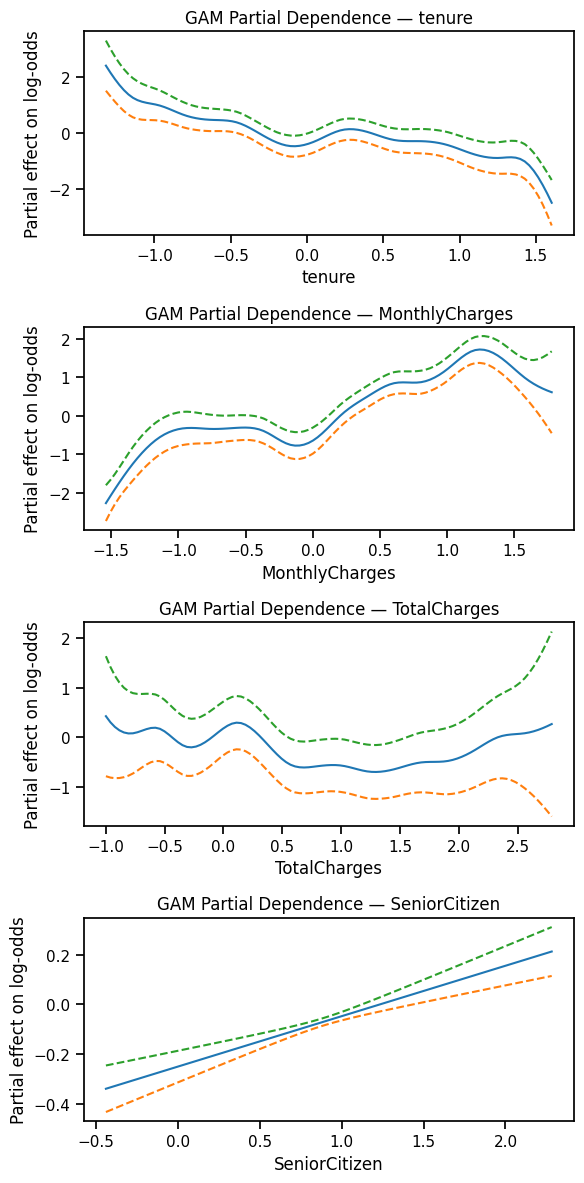

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     34.4958
Link Function:                        LogitLink Log Likelihood:                                 -2119.9548
Number of Samples:                         4930 AIC:                                             4308.9013
                                                AICc:                                            4309.4308
                                                UBRE:                                               2.8796
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2567
Feature Function                  Lam

In [ ]:
# Fit LogisticGAM with modest number of splines; gridsearch for lambda
from pygam import s as spline  # avoid confusion with pandas Series

# Impute missing values before scaling
imputer_g = SimpleImputer(strategy="median")
Xg_train_imp = imputer_g.fit_transform(Xg_train)
Xg_test_imp  = imputer_g.transform(Xg_test)

# Standardize continuous variables helps spline fitting
scaler_g = StandardScaler().fit(Xg_train_imp)
Xg_train_s = scaler_g.transform(Xg_train_imp)
Xg_test_s  = scaler_g.transform(Xg_test_imp)

# Build GAM terms correctly
terms = spline(0)
for i in range(1, Xg_train_s.shape[1]):
    terms = terms + spline(i)

gam = LogisticGAM(terms=terms).gridsearch(
    Xg_train_s, yg_train, lam=np.logspace(-3, 3, 7)
)

yg_proba = gam.predict_mu(Xg_test_s)  # predicted probabilities
gam_auc = roc_auc_score(yg_test, yg_proba)
print(f"GAM ROC-AUC: {gam_auc:.3f}")

# Partial dependence plots
fig, axes = plt.subplots(len(smooth_cols), 1, figsize=(6, 3*len(smooth_cols)))
if len(smooth_cols) == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], linestyle="--")
    ax.set_xlabel(smooth_cols[i])
    ax.set_ylabel("Partial effect on log-odds")
    ax.set_title(f"GAM Partial Dependence — {smooth_cols[i]}")
plt.tight_layout(); plt.show()

gam.summary()


## 4) Model Comparison & Recommendations

We summarize performance side‑by‑side and discuss interpretability trade‑offs.


In [ ]:
# Collect comparable metrics
results = []
results.append({"model":"Linear Regression", "ROC_AUC": linr_auc, "RMSE": rmse, "MAE": mae, "R2": r2})
results.append({"model":"Logistic Regression", "ROC_AUC": auc, "RMSE": np.nan, "MAE": np.nan, "R2": np.nan})
results.append({"model":"GAM (Logistic)", "ROC_AUC": gam_auc, "RMSE": np.nan, "MAE": np.nan, "R2": np.nan})

res_df = pd.DataFrame(results)
display(res_df)


,model,ROC_AUC,RMSE,MAE,R2
0,Linear Regression,0.831148,0.14284,0.297908,0.26752
1,Logistic Regression,0.844203,NaN,NaN,NaN
2,GAM (Logistic),0.827420,NaN,NaN,NaN


## Model Comparison

**Predictive Performance**  
Linear Regression reaches a ROC-AUC of about 0.83. It gives a baseline level of prediction but is not fully appropriate for a binary target, so the performance is less reliable. Logistic Regression performs the best with a ROC-AUC close to 0.84. It handles classification naturally and delivers the most consistent predictive accuracy. GAM (Logistic) has a ROC-AUC of about 0.83, which is slightly lower than logistic regression, but still competitive. Its strength is not only prediction but also capturing non-linear effects that may appear in variables like tenure or charges.

**Interpretability**
Linear Regression has coefficients that are easy to present, but the interpretation is misleading when applied to churn, because the model assumes a continuous outcome. Logistic Regression provides coefficients that can be turned into odds ratios, which directly describe how a feature increases or decreases the chance of churn. This makes the model both interpretable and aligned with the business problem. GAM is also interpretable, though in a different way. Instead of a single coefficient, it provides smooth curves that show how features affect churn across their range. This visual interpretation is valuable for analysts but is less direct to explain to non-technical managers.

**Summary**  
In terms of predictive performance, Logistic Regression is the best choice, with GAM close behind and Linear Regression only useful as a reference baseline. In terms of interpretability, Logistic Regression is the clearest and most practical for communication, while GAM adds richer insights into non-linear patterns. The recommendation is to use Logistic Regression as the main model and apply GAM as a supporting tool to explore non-linear effects, while leaving Linear Regression only for comparison.